In [1]:
# Libraries
import os
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings


In [2]:
# Configuration
image_size = 64
image_channels = 3
latent_dim = 100
batch_size = 64
epochs = 400
patience = 30
early_stop_threshold = 1.5
checkpoint_interval = 20  
dataset_path = "BloodCells_Cancer"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cell Types 
cell_types = ['Benign', 'Pre-B', 'Pro-B', 'Early Pre-B']
num_classes = len(cell_types)
label_dim = num_classes

# Directories  for cp's and training generated samples
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("generated_samples", exist_ok=True)


warnings.filterwarnings('ignore')


In [3]:
# Data Processing & Loading
class BloodCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for idx, label in enumerate(cell_types):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                images = glob.glob(f"{label_dir}/*.jpg") + glob.glob(f"{label_dir}/*.png")
                self.image_paths.extend(images)
                self.labels.extend([idx] * len(images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image, label_tensor

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


dataset = BloodCellDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [4]:
# The Model

# Generator (G)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, label_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + label_dim, 256 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, image_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_emb = self.label_embedding(labels)
        gen_input = torch.cat([z, label_emb], dim=1)
        return self.model(gen_input)

# Discriminator (D)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, label_dim)
        self.model = nn.Sequential(
            nn.Conv2d(image_channels + label_dim, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_emb = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        label_emb = label_emb.expand(-1, -1, image_size, image_size)
        x = torch.cat([x, label_emb], dim=1)
        return self.model(x)


G = Generator().to(device)
D = Discriminator().to(device)


loss_fn = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [5]:
# Training Loop

g_losses, d_losses = [], []
best_g_loss = float("inf")
no_improve_epochs = 0

for epoch in range(epochs):
    for real_imgs, labels in dataloader:
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        batch_size = real_imgs.size(0)

        # Real and fake labels
        real_labels = torch.full((batch_size, 1), 0.9, device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # Generate noise and fake labels
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z, labels)

        # Train Discriminator
        D.zero_grad()
        real_preds = D(real_imgs, labels)
        fake_preds = D(fake_imgs.detach(), labels)
        d_loss_real = loss_fn(real_preds, real_labels)
        d_loss_fake = loss_fn(fake_preds, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()

        # Train Generator
        G.zero_grad()
        fake_preds = D(fake_imgs, labels)
        g_loss = loss_fn(fake_preds, real_labels)
        g_loss.backward()
        opt_G.step()

    # losses
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save checkpoint 
    if (epoch + 1) % checkpoint_interval == 0 or g_loss.item() < best_g_loss:
        torch.save(G.state_dict(), f"checkpoints/generator_epoch_{epoch + 1}.pth")
        torch.save(D.state_dict(), f"checkpoints/discriminator_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")
        best_g_loss = min(best_g_loss, g_loss.item())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    # Early stopping
    if no_improve_epochs >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

print("Training complete.")


Epoch 1/400 | D Loss: 0.8099 | G Loss: 3.3147
Checkpoint saved at epoch 1
Epoch 2/400 | D Loss: 0.5090 | G Loss: 2.6494
Checkpoint saved at epoch 2
Epoch 3/400 | D Loss: 0.8922 | G Loss: 2.0297
Checkpoint saved at epoch 3
Epoch 4/400 | D Loss: 1.2886 | G Loss: 0.8116
Checkpoint saved at epoch 4
Epoch 5/400 | D Loss: 0.6541 | G Loss: 2.3047
Epoch 6/400 | D Loss: 0.6897 | G Loss: 2.6879
Epoch 7/400 | D Loss: 1.7553 | G Loss: 0.6870
Checkpoint saved at epoch 7
Epoch 8/400 | D Loss: 1.1341 | G Loss: 0.4030
Checkpoint saved at epoch 8
Epoch 9/400 | D Loss: 0.9254 | G Loss: 1.4089
Epoch 10/400 | D Loss: 1.2057 | G Loss: 0.8954
Epoch 11/400 | D Loss: 0.9603 | G Loss: 2.2372
Epoch 12/400 | D Loss: 0.9309 | G Loss: 2.7754
Epoch 13/400 | D Loss: 0.6490 | G Loss: 2.7586
Epoch 14/400 | D Loss: 0.8234 | G Loss: 1.8086
Epoch 15/400 | D Loss: 0.9262 | G Loss: 3.1044
Epoch 16/400 | D Loss: 1.1026 | G Loss: 2.6792
Epoch 17/400 | D Loss: 0.6300 | G Loss: 2.1247
Epoch 18/400 | D Loss: 0.7413 | G Loss: 1.

KeyboardInterrupt: 

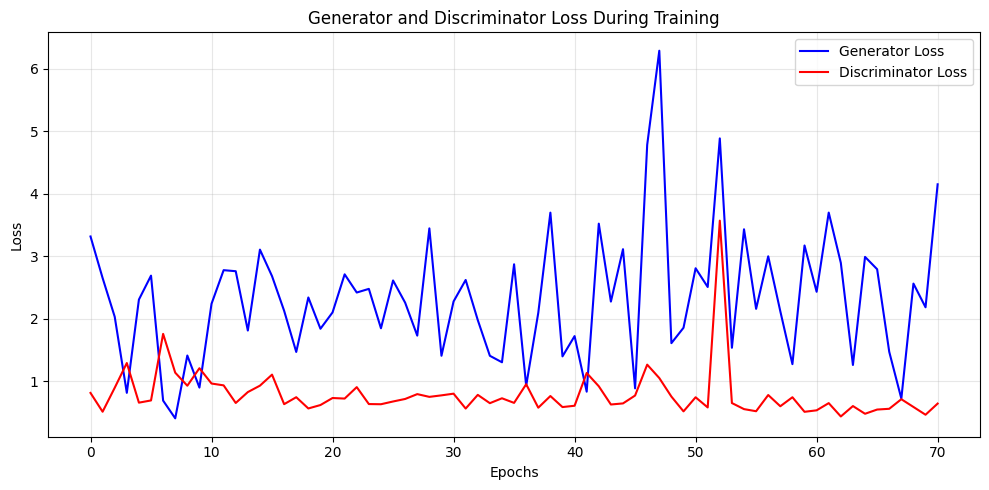

In [6]:
# Losses Plot

def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label="Generator Loss", color='blue')
    plt.plot(d_losses, label="Discriminator Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Loss During Training")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the function after training
plot_losses(g_losses, d_losses)


In [7]:
# Save final models
torch.save(G.state_dict(), "checkpoints/final_generator.pth")
torch.save(D.state_dict(), "checkpoints/final_discriminator.pth")
print("Models saved successfully.")


Models saved successfully.


In [8]:
# Image Generation

def load_model():
    """Load the trained generator model."""
    try:
        generator = Generator().to(device)
        generator.load_state_dict(torch.load("checkpoints/final_generator.pth", map_location=device))
        generator.eval()
        print("Model loaded successfully!")
        return generator
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None


generator = load_model()

def generate_image(cell_type):
    """Generate an image for a specific cell type."""
    if generator is None:
        print("Generator not loaded!")
        return None

    label_idx = cell_types.index(cell_type)
    label_tensor = torch.tensor([label_idx], dtype=torch.long).to(device)
    
    z = torch.randn(1, latent_dim).to(device)

    with torch.no_grad():
        generated_img = generator(z, label_tensor).squeeze(0).cpu()

    generated_img = (generated_img * 0.5 + 0.5).clamp(0, 1)
    return transforms.ToPILImage()(generated_img)

def generate_and_display(cell_type):
    """Display the generated image for the selected cell type."""
    img = generate_image(cell_type)
    if img:
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Generated {cell_type} Cell")
        plt.show()

# Widget Setup
cell_dropdown = widgets.Dropdown(
    options=cell_types,
    value=cell_types[0],
    description='Cell Type:',
    style={'description_width': 'initial'}
)

generate_button = widgets.Button(
    description="Generate Image",
    button_style='success',
    icon='image'
)

output_area = widgets.Output()

def on_button_click(b):
    with output_area:
        clear_output(wait=True)
        generate_and_display(cell_dropdown.value)

generate_button.on_click(on_button_click)

# Display UI
controls = widgets.HBox([cell_dropdown, generate_button])
ui = widgets.VBox([controls, output_area], layout=widgets.Layout(border='solid 1px gray', padding='10px'))
display(ui)

Model loaded successfully!


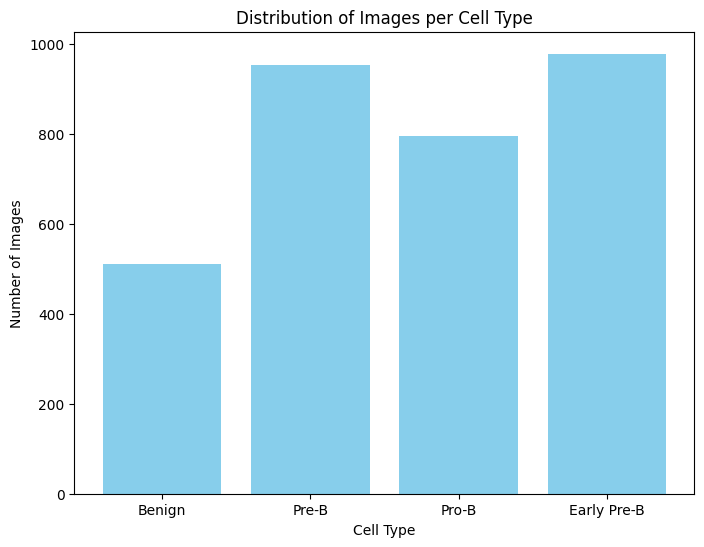

In [ ]:
# Data Distribution Plot 
import matplotlib.pyplot as plt
import os
import glob


cell_types = ['Benign', 'Pre-B', 'Pro-B', 'Early Pre-B']
dataset_path = "BloodCells_Cancer"


image_counts = {cell_type: 0 for cell_type in cell_types}


for label in cell_types:
    label_dir = os.path.join(dataset_path, label)
    if os.path.isdir(label_dir):
        images = glob.glob(f"{label_dir}/*.jpg") + glob.glob(f"{label_dir}/*.png")
        image_counts[label] = len(images)


labels = list(image_counts.keys())
counts = list(image_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Cell Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Cell Type')
plt.show()


### Generated Samples folder is from 1st model